The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


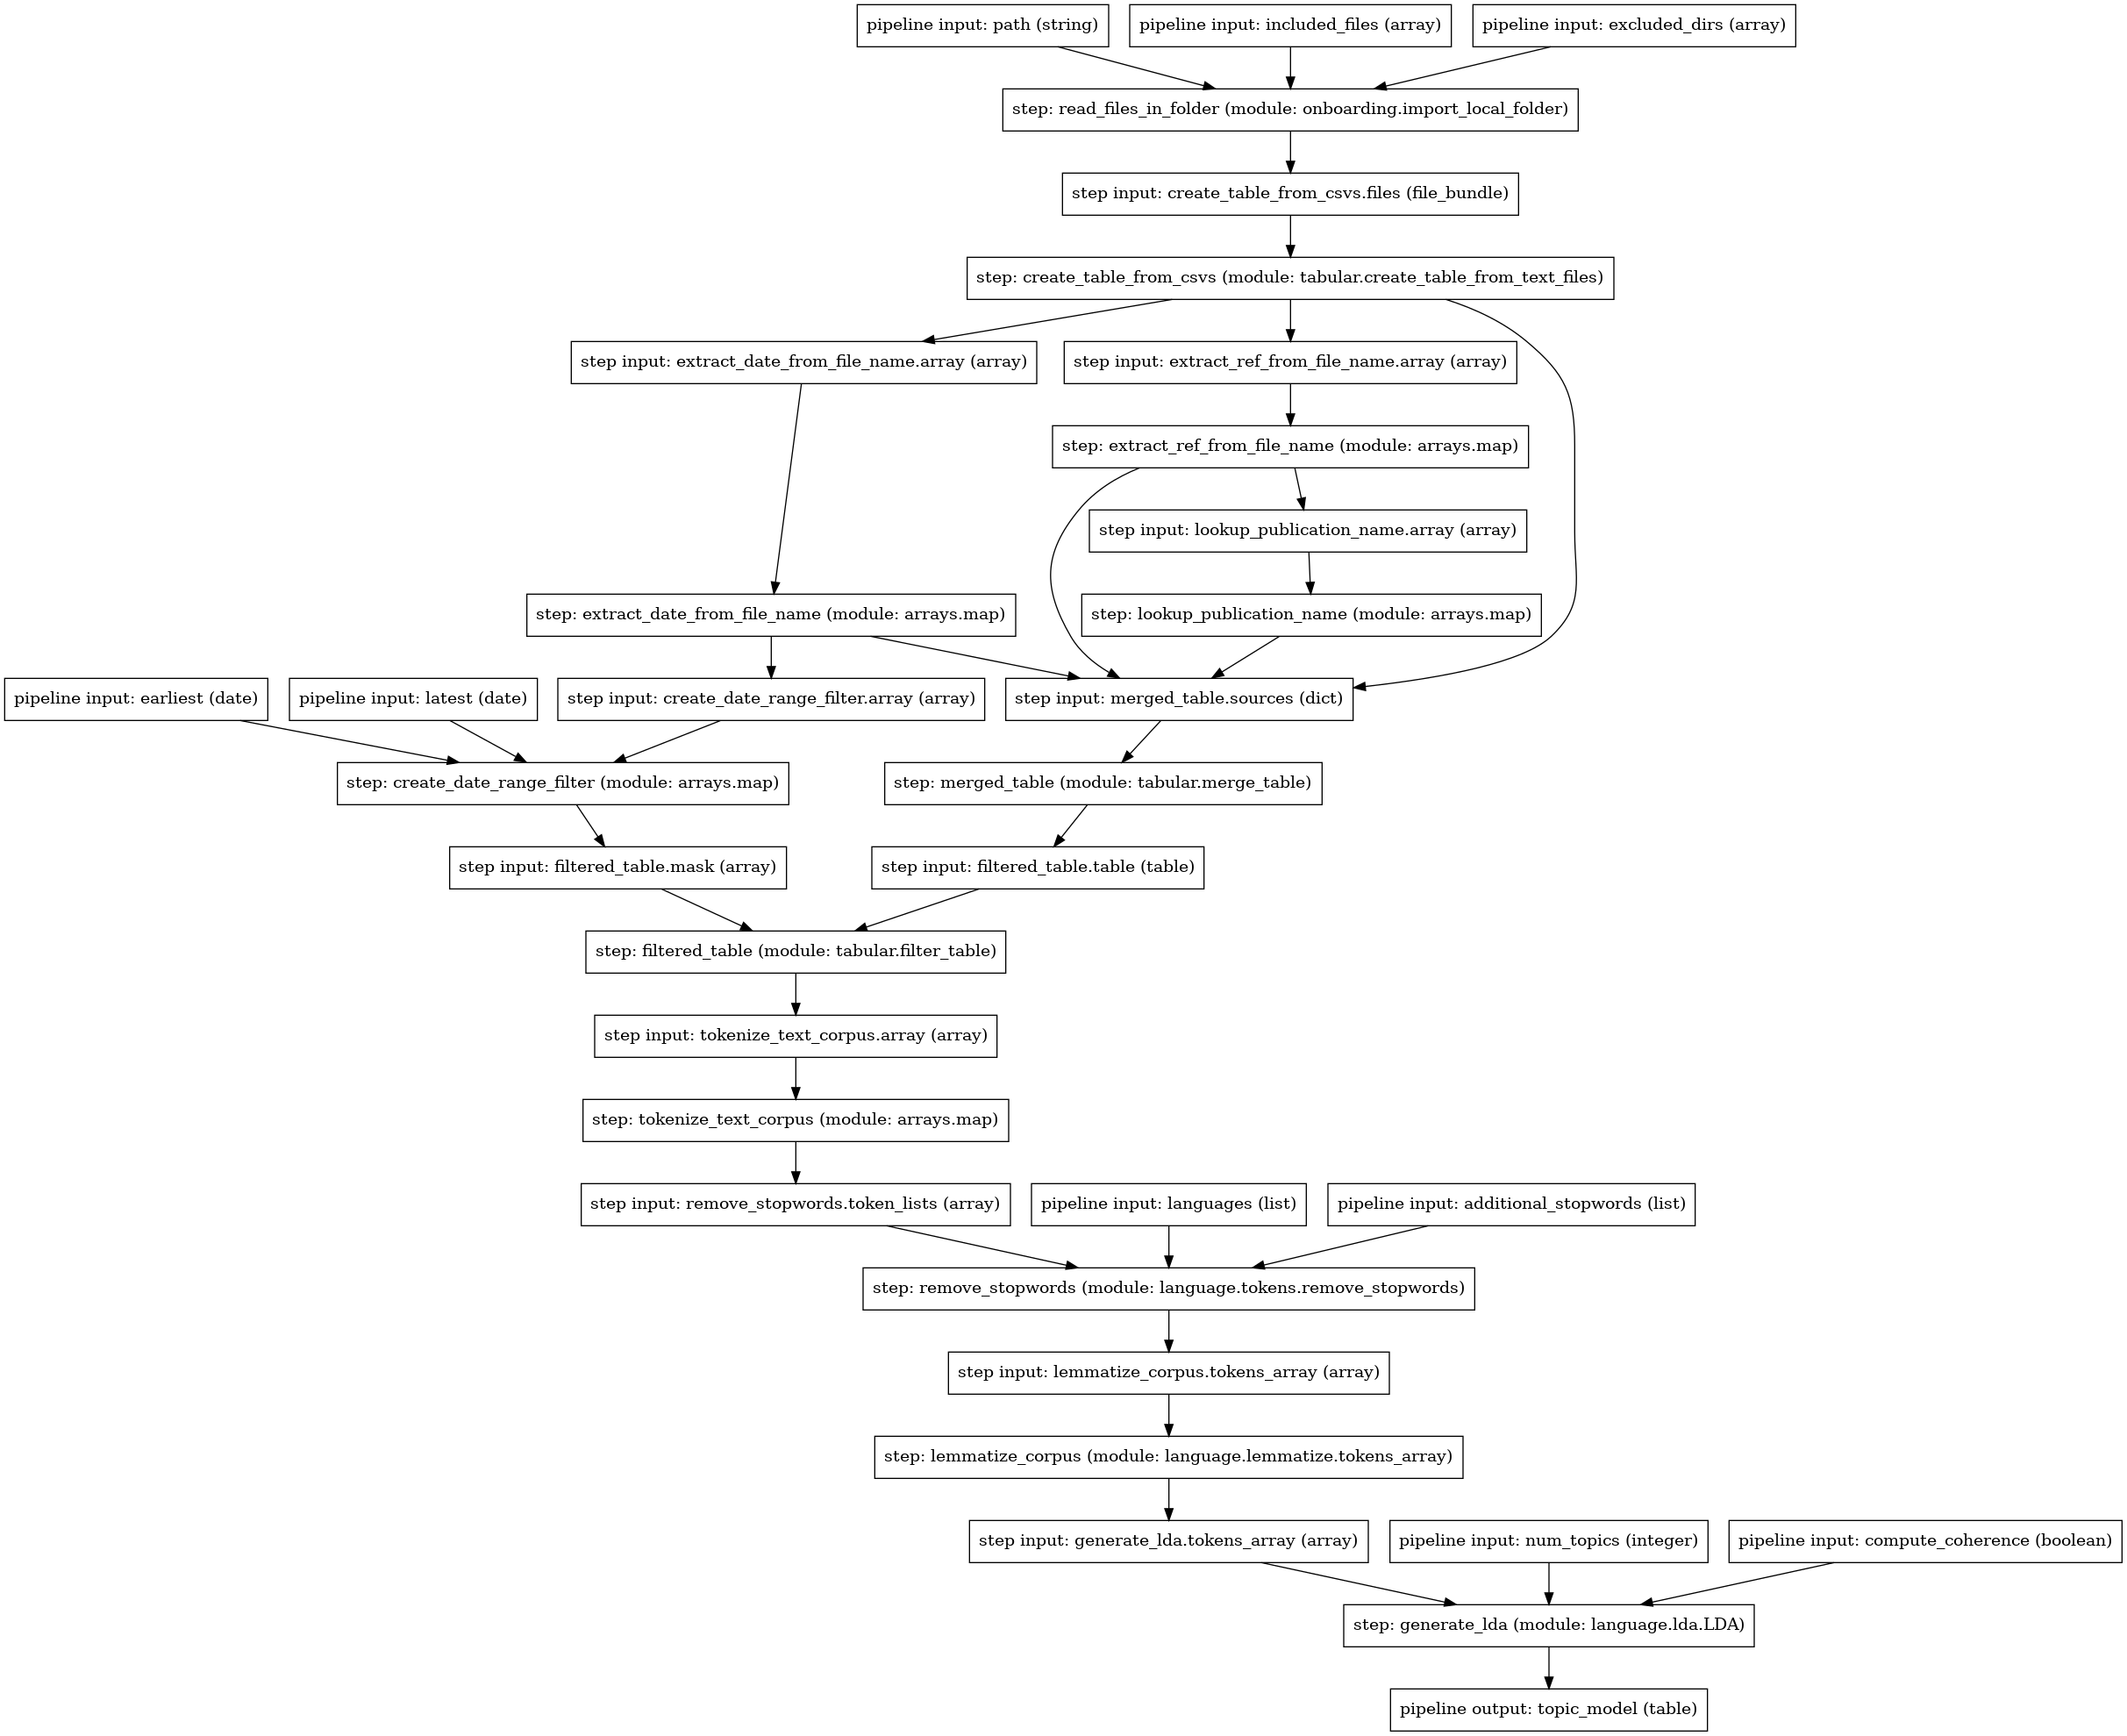

In [8]:
%load_ext autoreload
%autoreload 2

from kiara import Kiara
from rich.jupyter import print

from kiara.utils.jupyter import graph_to_image, save_image

kiara: Kiara = Kiara.instance()

# print(kiara.available_module_types)

# # print('---')
workflow = kiara.create_workflow("language.topic_modeling")
#
# kiara.explain(workflow.steps)
#
save_image(workflow.structure.data_flow_graph_simple, path="/tmp/data_flow.png")

graph_to_image(workflow.structure.data_flow_graph_simple)
